Stock Market Prediction using Stacked **LSTM**

In [1]:
### Data Collection ## Use your key from tiingo website 
import pandas_datareader as pdr
key=""

In [2]:
df = pdr.get_data_tiingo('TSLA', api_key=key)

In [3]:
df.to_csv('TSLA.csv')

In [4]:
import pandas as pd

In [5]:
df=pd.read_csv('TSLA.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,TSLA,2016-02-08 00:00:00+00:00,147.99,157.15,146.00,157.105,9312988,29.598,31.430,29.200,31.421,46564940,0.0,1.0
1,TSLA,2016-02-09 00:00:00+00:00,148.25,159.79,141.05,142.320,8651648,29.650,31.958,28.210,28.464,43258240,0.0,1.0
2,TSLA,2016-02-10 00:00:00+00:00,143.67,154.97,141.74,150.500,10406513,28.734,30.994,28.348,30.100,52032565,0.0,1.0
3,TSLA,2016-02-11 00:00:00+00:00,150.47,163.26,147.00,152.000,14252364,30.094,32.652,29.400,30.400,71261820,0.0,1.0
4,TSLA,2016-02-12 00:00:00+00:00,151.04,157.01,143.70,155.000,7235783,30.208,31.402,28.740,31.000,36178915,0.0,1.0


In [6]:
df1=df.reset_index()['close']

In [7]:
df1

0       147.99
1       148.25
2       143.67
3       150.47
4       151.04
         ...  
1253    793.53
1254    839.81
1255    872.79
1256    854.69
1257    849.99
Name: close, Length: 1258, dtype: float64

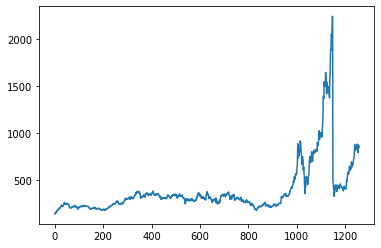

In [8]:
import matplotlib.pyplot as plt
plt.plot(df1)

LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
print(df1)

[[0.00206197]
 [0.00218607]
 [0.        ]
 ...
 [0.34801535]
 [0.33937606]
 [0.33713271]]


In [12]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(880, 378)

In [14]:
# convert an array of values into a dataset matrix
def new_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = new_dataset(train_data, time_step)
X_test, ytest = new_dataset(test_data, time_step)

In [16]:
print(X_train.shape), print(y_train.shape)

(779, 100)
(779,)


(None, None)

In [17]:
print(X_test.shape), print(ytest.shape)

(277, 100)
(277,)


(None, None)

In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:

model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 8s 278ms/step - loss: 0.0019 - val_loss: 0.0598
Epoch 2/100
13/13 [==============================] - 3s 202ms/step - loss: 3.8857e-04 - val_loss: 0.0465
Epoch 3/100
13/13 [==============================] - 2s 189ms/step - loss: 2.7233e-04 - val_loss: 0.0268
Epoch 4/100
13/13 [==============================] - 2s 189ms/step - loss: 1.6007e-04 - val_loss: 0.0200
Epoch 5/100
13/13 [==============================] - 2s 190ms/step - loss: 1.2786e-04 - val_loss: 0.0198
Epoch 6/100
13/13 [==============================] - 2s 187ms/step - loss: 1.1341e-04 - val_loss: 0.0200
Epoch 7/100
13/13 [==============================] - 3s 237ms/step - loss: 1.1032e-04 - val_loss: 0.0188
Epoch 8/100
13/13 [==============================] - 3s 198ms/step - loss: 9.2211e-05 - val_loss: 0.0186
Epoch 9/100
13/13 [==============================] - 3s 196ms/step - loss: 9.8987e-05 - val_loss: 0.0180
Epoch 10/100
13/13 [==============================] - 3s 19

In [24]:
import tensorflow as tf

In [25]:
tf.__version__

'2.4.1'

In [26]:
## Prediction and checking performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [27]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [28]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

292.7602784262373

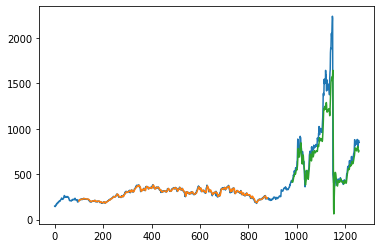

In [30]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [31]:
len(test_data)

378

In [33]:
x_input=test_data[278:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
temp_input

[0.13171334746167213,
 0.14609943295721406,
 0.14228096301811866,
 0.13353189377016633,
 0.14246711342764956,
 0.14592282872253087,
 0.13391374076407586,
 0.11297420623556144,
 0.11652061019149627,
 0.12585199610516068,
 0.13246749527464347,
 0.1314508276533593,
 0.13619527655268532,
 0.145335738969395,
 0.12955113885865932,
 0.13460583844053686,
 0.12902132615460987,
 0.13442446111842987,
 0.13472039253870977,
 0.1385770471771961,
 0.14253870973900762,
 0.14461500276839068,
 0.1516075758443592,
 0.14567940126391354,
 0.14128338774653,
 0.13706397846382956,
 0.13282070374400978,
 0.1331548198636806,
 0.13465834240219948,
 0.13219542929148292,
 0.13202837123164746,
 0.13412852969814998,
 0.1252219485652099,
 0.12751780361609105,
 0.11663993737709301,
 0.12259197739465798,
 0.13375622887908817,
 0.13236248735131834,
 0.1405292399335586,
 0.13664394677052905,
 0.13249613379918668,
 0.12729346850716922,
 0.1305248486931287,
 0.12796170074651086,
 0.12640567424632948,
 0.12620997766195086,


In [45]:
# demonstrate prediction for next 100 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<100):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.24161846 0.21994864 0.23073105 0.22257861 0.23682151 0.23368081
 0.22867862 0.24449186 0.26315463 0.24160891 0.23706493 0.23975695
 0.24729366 0.24821009 0.2493079  0.26304962 0.26824751 0.27975065
 0.28229948 0.29226092 0.32092808 0.35146629 0.31861313 0.33687019
 0.33924242 0.33475094 0.32575844 0.33453615 0.33735227 0.33474617
 0.33553373 0.35183859 0.35293163 0.34389618 0.3301831  0.31018386
 0.33227371 0.34801535 0.33937606 0.33713271 0.30769989 0.29756686
 0.28066978 0.26216373 0.24439077 0.22840165 0.21472566 0.20358062
 0.1949252  0.18850881 0.18393998 0.18075815 0.17849667 0.17673154
 0.17511293 0.17338271 0.17137815 0.16902506 0.16632414 0.16333191
 0.16014053 0.1568585  0.15359396 0.15044208 0.14747699 0.14474781
 0.14227864 0.14007114 0.13810901 0.13636343 0.13479844 0.13337587
 0.13205934 0.13081709 0.12962383 0.12846129 0.12731813 0.12618907
 0.12507358 0.12397462 0.12289704 0.1218465  0.1208284  0.11984713
 0.11890567 0.11800545 0.11714648 0.11632732 0.115

In [49]:
day_new=np.arange(1,101)
day_pred=np.arange(101,201)

In [39]:
import matplotlib.pyplot as plt

In [50]:

len(df1)


1258

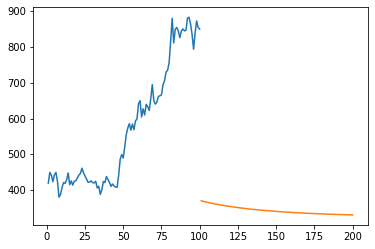

In [51]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

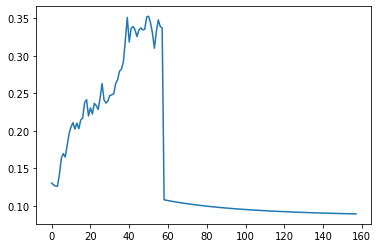

In [52]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [43]:
df3=scaler.inverse_transform(df3).tolist()

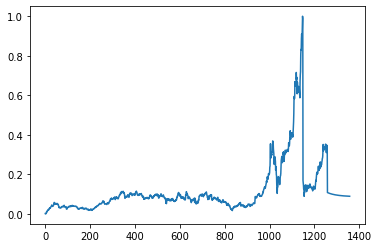

In [53]:
plt.plot(df3)